In [1]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tf2lib as tl
import DLlib as dl
import pylib as py
import wflib as wf

from itertools import cycle
from time import process_time

In [2]:
# Dataset directory - Read DICOM files
ds_dir = py.join('..','FF')
dicoms_dir = os.listdir(ds_dir)
prev_d_dir = ''
X_complex = None
X_echs = list()
TEs = list()
for d_dir in dicoms_dir:
    dicom_dir = py.join(ds_dir,d_dir)
    if os.path.isdir(dicom_dir):
        dicom_fns = os.listdir(dicom_dir)
        X_aux = None
        for dicom_fn in dicom_fns:
            ds = pydicom.dcmread(py.join(dicom_dir,dicom_fn))
            if X_aux is None:
                arr = ds.pixel_array #.transpose()
                X_aux = apply_modality_lut(arr, ds).astype(np.float32)
                X_aux = np.reshape(X_aux,(1,1,X_aux.shape[0],X_aux.shape[1],1))
                TE_aux = np.array([[np.float(ds.EchoTime) * 1e-3]]).astype(np.float32)
            else:
                arr = ds.pixel_array #.transpose()
                X_aux_2 = apply_modality_lut(arr, ds).astype(np.float32)
                X_aux_2 = np.reshape(X_aux_2,(1,1,X_aux_2.shape[0],X_aux_2.shape[1],1))
                TE_aux_2 = np.array([[np.float(ds.EchoTime) * 1e-3]]).astype(np.float32)
                X_aux = np.concatenate((X_aux,X_aux_2), axis=0)
                TE_aux = np.concatenate((TE_aux,TE_aux_2), axis=0)
        # X_aux shape: (5,1,H,W,1)
        if X_complex is None:
            X_complex = X_aux / (np.max(X_aux)*1.4)
            TEs.append(TE_aux)
        else:
            if int(d_dir.split('_')[-1]) == int(prev_d_dir.split('_')[-1]):
                X_aux *= np.pi/4094
                X_echs.append(np.concatenate((X_complex,X_aux), axis=-1))
                X_complex = None
        prev_d_dir = d_dir
X = np.concatenate(X_echs,axis=1)
TEs = np.concatenate(TEs,axis=1)
TEs = np.expand_dims(TEs,axis=-1)

In [3]:
# Change data from mag-phase format to real-imag
X_real = X[...,:1] * np.cos(X[...,1:])
X_imag = X[...,:1] * np.sin(X[...,1:])
X = np.concatenate((X_real,X_imag), axis=-1)

In [4]:
# Build tensorflow dataset
A_dataset = tf.data.Dataset.from_tensor_slices((X,TEs))
test_iter = cycle(A_dataset)

In [5]:
# Create VET-Net and load weights
experiment_dir = py.join('output','TEaug-301')
args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))

input_shape = (None,None,None,2)
G_A2B = dl.PM_Generator(input_shape=input_shape, te_input=args.te_input, te_shape=(None,), filters=args.n_G_filters)
tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints')).restore()

output\TEaug-301\checkpoints\ckpt-79

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000026306854940> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x0000026306886AC0>).

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.normalizations.InstanceNormalization object at 0x0000026306857070> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000026306868280>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000026306882FD0> and <tensorflow_addons.layers.normalizations.InstanceNormalization object at 0x0000026306857070>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent.RNN object at 0x000002630686C3D0> and <tensorflow.python.keras.layers.core.Lambda object at 0x000002630682F5B0>).

Two checkpoint references resolved to diffe

In [6]:
# Sample function
@tf.function
def sample(A, TE):
    A2B_PM = G_A2B([A,TE], training=False)
    A2B_PM = tf.where(A[:,:1,:,:,:]!=0.0,A2B_PM,0.0)
    A2B_R2 = A2B_PM[:,:,:,:,1:]
    A2B_FM = A2B_PM[:,:,:,:,:1]
    A2B_WF = wf.get_rho(A, A2B_PM, field=args.field, te=TE)
    A2B = tf.concat([A2B_WF,A2B_PM],axis=1)
    return A2B

def test(A, TE=None):
    A2B = sample(A, TE)
    return A2B

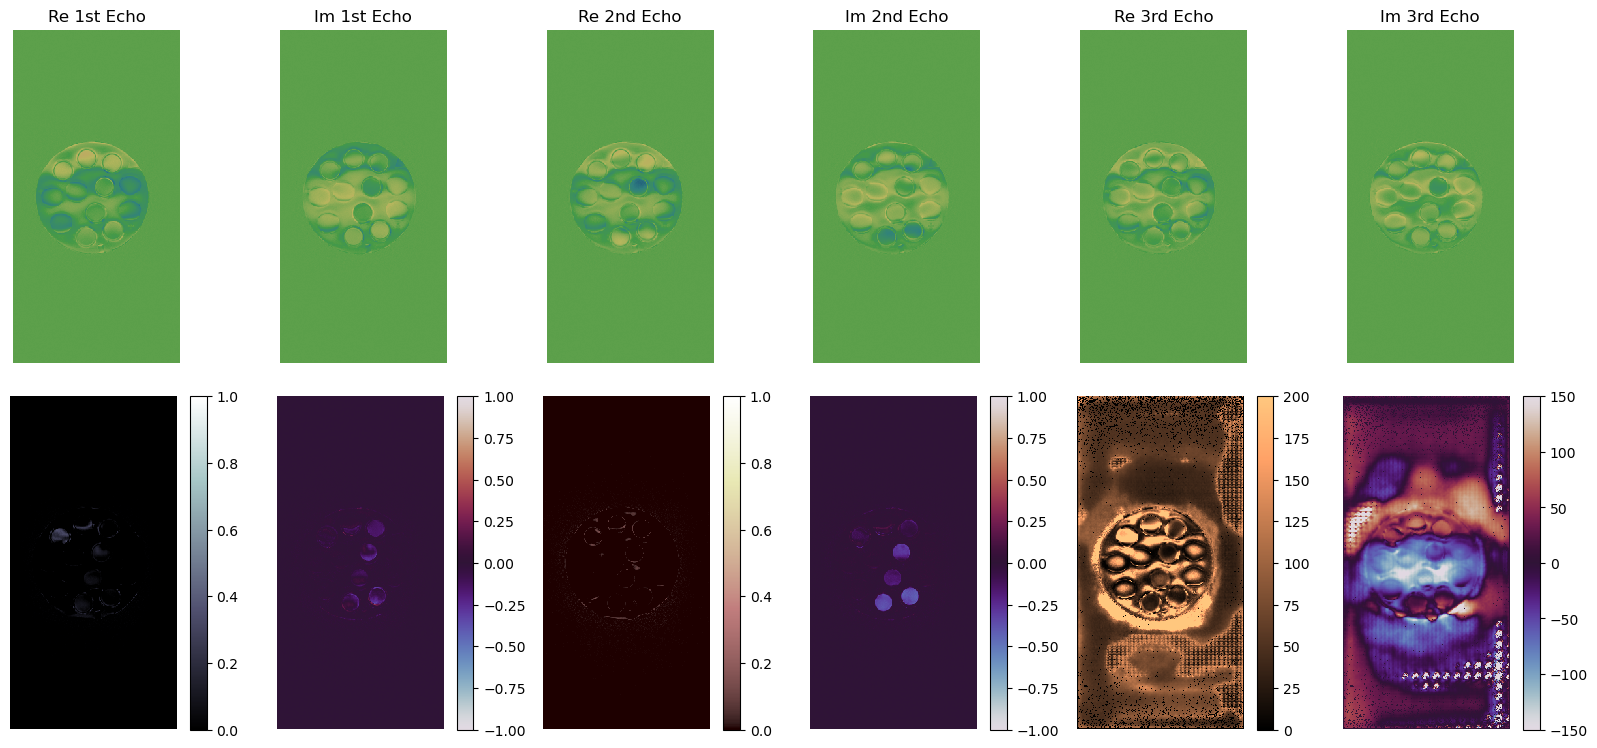

In [7]:
A, TE = next(test_iter)
A = tf.expand_dims(A,axis=0)
TE = tf.expand_dims(TE,axis=0)

fm_sc = 300.0
r2_sc = 200.0

A2B = test(A, TE)

fig, axs = plt.subplots(figsize=(16, 7), nrows=2, ncols=6)

# Recon MR images at each echo
re_ech1 = np.squeeze(A[:,0,:,:,0])
re_ech2 = np.squeeze(A[:,1,:,:,0])
re_ech3 = np.squeeze(A[:,2,:,:,0])
im_ech1 = np.squeeze(A[:,0,:,:,1])
im_ech2 = np.squeeze(A[:,1,:,:,1])
im_ech3 = np.squeeze(A[:,2,:,:,1])

# Acquisitions in the first row
acq_ech1 = axs[0,0].imshow(re_ech1, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[0,0].set_title('Re 1st Echo')
axs[0,0].axis('off')
acq_ech2 = axs[0,1].imshow(im_ech1, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[0,1].set_title('Im 1st Echo')
axs[0,1].axis('off')
acq_ech3 = axs[0,2].imshow(re_ech2, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,2].set_title('Re 2nd Echo')
axs[0,2].axis('off')
acq_ech4 = axs[0,3].imshow(im_ech2, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,3].set_title('Im 2nd Echo')
axs[0,3].axis('off')
acq_ech5 = axs[0,4].imshow(re_ech3, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,4].set_title('Re 3rd Echo')
axs[0,4].axis('off')
acq_ech6 = axs[0,5].imshow(im_ech3, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,5].set_title('Im 3rd Echo')
axs[0,5].axis('off')

# A2B maps in the second row
w_m_aux = np.squeeze(A2B[:,0,:,:,0])
w_p_aux = np.squeeze(A2B[:,1,:,:,0])
f_m_aux = np.squeeze(A2B[:,0,:,:,1])
f_p_aux = np.squeeze(A2B[:,1,:,:,1])
r2_aux = np.squeeze(A2B[:,2,:,:,1])
field_aux = np.squeeze(A2B[:,2,:,:,0])

W_ok =  axs[1,0].imshow(w_m_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[1,0])
axs[1,0].axis('off')

Wp_ok =  axs[1,1].imshow(w_p_aux, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Wp_ok, ax=axs[1,1])
axs[1,1].axis('off')

F_ok =  axs[1,2].imshow(f_m_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[1,2])
axs[1,2].axis('off')

Fp_ok =  axs[1,3].imshow(f_p_aux, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Fp_ok, ax=axs[1,3])
axs[1,3].axis('off')

r2_ok = axs[1,4].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[1,4])
axs[1,4].axis('off')

field_ok =  axs[1,5].imshow(field_aux*fm_sc, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[1,5])
axs[1,5].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
plt.show()

C:\Users\jpmen\AppData\Local\Temp\ipykernel_12856\4281989159.py:13: RuntimeWarning: invalid value encountered in true_divide
  PDFFn_aux = np.squeeze(fn_aux/(wn_aux+fn_aux))


Elapsed time during the whole program in seconds: 0.703125


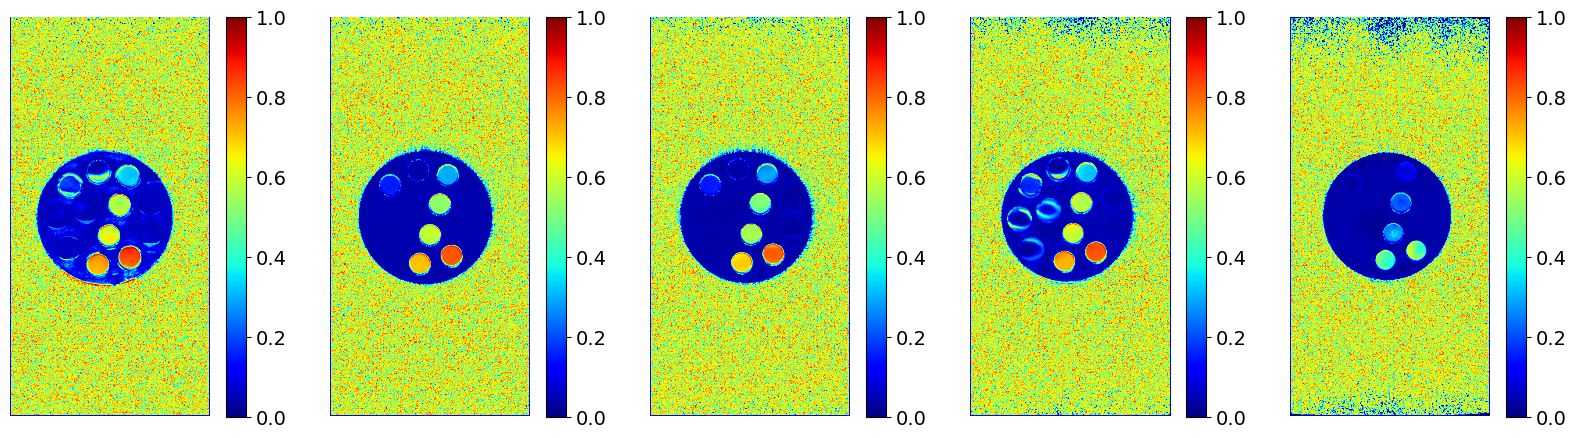

In [8]:
# PDFF maps
fig, axs = plt.subplots(figsize=(16, 4), ncols=X.shape[0])

t1 = process_time()
for i, (A, TE) in enumerate(A_dataset):
    A = tf.expand_dims(A,axis=0)
    TE = tf.expand_dims(TE,axis=0)
    
    A2B = test(A, TE)
    
    wn_aux = np.abs(tf.complex(A2B[:,0,:,:,0],A2B[:,0,:,:,1]))
    fn_aux = np.abs(tf.complex(A2B[:,1,:,:,0],A2B[:,1,:,:,1]))
    PDFFn_aux = np.squeeze(fn_aux/(wn_aux+fn_aux))
    PDFFn_aux[np.isnan(PDFFn_aux)] = 0.0

    F_unet = axs[i].imshow(PDFFn_aux, cmap='jet', vmin=0, vmax=1)
    fig.colorbar(F_unet, ax=axs[i]).ax.tick_params(labelsize=14)
    axs[i].axis('off')

t2 = process_time()
print("Elapsed time during the whole program in seconds:",t2-t1)

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
# plt.show()
plt.savefig(py.join(experiment_dir,'PDFF_results.png'),
                        bbox_inches = 'tight', pad_inches = 0)